In [5]:
import numpy as np 
import mdtraj as md
from molecular_mpns.config import data_dir, fig_dir
from molecular_mpns.vae import VAE, VAEloss
from molecular_mpns.data import AlanineDipeptideGraph
from torch_geometric.data import DataLoader
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import ExponentialLR
import os

In [6]:
# load training trajectory
os.chdir(data_dir)
os.chdir('alanine_dipeptide/')
xtc_file = 'alanine-dipeptide-0-250ns-nowater.xtc'
top_file = 'alanine-dipeptide-nowater.pdb'
traj = md.load(xtc_file,top=top_file)

In [7]:
# create graphs
batch_size = 32
z = [atom.element.atomic_number for atom in traj.topology.atoms]
G = [AlanineDipeptideGraph(z = torch.tensor(z).long(),pos = torch.tensor(xyz)) for xyz in traj.xyz]

In [8]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_spherical': 16, 'num_radial': 6, 'hidden_channels': 64, 'num_bilinear': 4, 'out_channels': 64, 'num_layers': 2, 'num_blocks': 1,
         'num_enc_lins': 4, 'num_dec_lins': 4, 'enc_act': torch.tanh, 'dec_act': torch.tanh, 'dec_hidden_channels': 64, 'dec_var_const': False,
         'cutoff': 0.5, 'zdim': 2}

mod = VAE(**kwargs)
mod = mod.to(device)

In [9]:
# train-test split

def train_test_split(data, subset_size, train_prop, seed = 42):
    
    np.random.seed(seed)
    assert subset_size < len(data)
    random_idx = np.random.choice(len(data), subset_size, replace = False)
    
    assert train_prop < 1
    train_size = int(train_prop*subset_size)
    train_idx, test_idx = random_idx[0:train_size], random_idx[train_size:]
    
    train, test = [data[i] for i in train_idx], [data[i] for i in test_idx]
    
    return train, test

subset_size, train_prop  = 500, 0.5
train, test = train_test_split(data = G,subset_size = subset_size, train_prop = train_prop)

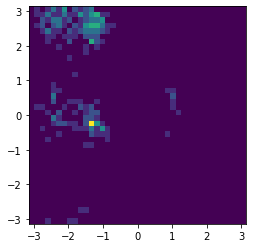

In [10]:
# plot dihedrals

def plot_dihedrals(traj_xyz, topology, bins = 40, rng = [[-np.pi,np.pi],[-np.pi, np.pi]],psi_inds = [6, 8, 14, 16], phi_inds = [4, 6, 8, 14]):
    traj = md.Trajectory(traj_xyz, topology = topology)
    dihedrals = md.compute_dihedrals(traj,[psi_inds,phi_inds])
    psi, phi = dihedrals[:,1], dihedrals[:,0]
    
    plt.hist2d(psi, phi, bins = bins, range = rng)
    plt.gca().set_aspect('equal')
    plt.show()
    plt.close()
    
    return dihedrals
    
traj_xyz = np.array([mol.pos.cpu().numpy() for mol in train])

dihedrals = plot_dihedrals(traj_xyz = traj_xyz, topology = traj.topology)

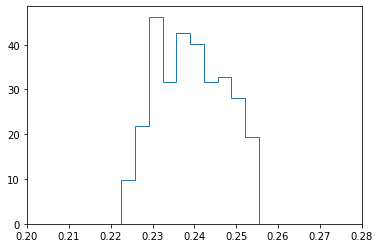

In [11]:
# radius of gyration
def radius_of_gyration(xyz, topology):
    masses = np.array([atom.element.mass for atom in topology.atoms])
    total_mass = masses.sum()
    com = np.array([m*x for m,x in zip(masses,xyz)]).sum(axis = 0) / total_mass
    
    r_sq = ((xyz - com)**2).sum(axis = 1) 
    rog_sq = (masses*r_sq).sum() / total_mass
    
    return np.sqrt(rog_sq)

rog = radius_of_gyration(traj_xyz[0], topology = traj.topology)

def plot_rogs(traj_xyz, topology, density = True, xlims = [0.2, 0.28], histtype = 'step'):
    rogs = [radius_of_gyration(xyz, topology = topology) for xyz in traj_xyz]
    
    plt.hist(rogs, density = density, histtype = histtype)
    plt.xlim(xlims)
    plt.show()
    plt.close()
    
    return rogs

rogs = plot_rogs(traj_xyz = traj_xyz, topology = traj.topology)


In [12]:
# ancestral sampler

def ancestral_sample(mod, T, device ,dim_z = 2, n_atoms = 22):
    w = torch.randn((T, dim_z))
    with torch.no_grad():
        mu_dec, logvar_dec = mod.decode(w.to(device))
        x_recon = mod.reparameterize(mu_dec, logvar_dec)
    
    x_recon = x_recon.cpu().numpy()
    x_recon = x_recon.reshape((T, n_atoms ,3))
    return x_recon

x_recon = ancestral_sample(mod = mod , T = 250, device = device)

In [13]:
# metropolis within gibbs

# initialize
z0 = torch.randn((1,2)).to(device)
x0 = torch.tensor(traj_xyz[0])

G_batch = [AlanineDipeptideGraph(z = torch.tensor(z).long(), pos = x0)]
loader = DataLoader(G_batch, batch_size = 1)

# draw proposal z_t
for g in loader:
    g = g.to(device)
    with torch.no_grad():
        mu_x0, logvar_x0 = mod.encode(g)
        var_x0 = torch.exp(0.5*logvar_x0)
        znext = mod.reparameterize(mu_x0, logvar_x0)
        
# compute params for p(x | z)
with torch.no_grad():
    mu_z0, logvar_z0 = mod.decode(z0)
    var_z0 = torch.exp(0.5*logvar_z0)
    mu_znext, logvar_znext = mod.decode(znext.to(device))
    var_znext = torch.exp(0.5*logvar_znext)
    
# compute p(x_{t-1} | z_t) and p(x_{t-1} | z_{t-1})
p_z0 = torch.exp(-0.5*(((x0.flatten().to(device) - mu_z0)*(1/var_z0)).pow(2).sum()))
p_znext = torch.exp(-0.5*(((x0.flatten().to(device) - mu_znext)*(1/var_znext)).pow(2).sum()))
            
# compute p(z_t) and p(z_{t-1})
pri_z0 = torch.exp(-0.5*(z0.pow(2).sum()))
pri_znext = torch.exp(-0.5*(znext.pow(2).sum()))

# compute q(z_t | x_{t-1}) and q(z_{t-1} | x_{t-1})
q_z0 = torch.exp(-0.5*(((z0 - mu_x0)*(1/var_x0)).pow(2).sum()))
q_znext = torch.exp(-0.5*(((znext - mu_x0)*(1/var_x0)).pow(2).sum()))

# compute acceptance ratio
ar = ((p_znext/p_z0)*(pri_znext/pri_z0)*(q_z0 / q_znext)).item()

# update z0 and x0
u = np.random.rand()
accept = u < ar

z_t = znext if accept else z0
with torch.no_grad():
    mu_zt, logvar_zt = mod.decode(z_t)
    x_t = mod.reparameterize(mu_zt, logvar_zt)
x_t = x_t.reshape((22,3))

In [14]:
# test VAE metropolis within gibbs method
z0 = torch.randn((1,2)).to(device)
x0 = torch.tensor(traj_xyz[0])
atomic_numbers = z

T = 250
xyz_samples = np.zeros((T,22,3))

for t in range(T):
    z0, x0 = mod.mwg_sample(z0, x0, atomic_numbers)
    xyz_samples[t,:,:] = x0.cpu().numpy()

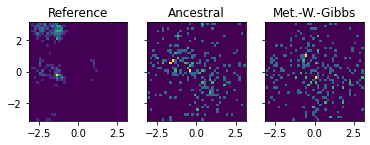

In [15]:
def compare_dihedrals(traj_xyz_ref, traj_xyz_ancestral, traj_xyz_mwg ,topology, bins = 40, rng = [[-np.pi,np.pi],[-np.pi, np.pi]],psi_inds = [6, 8, 14, 16], phi_inds = [4, 6, 8, 14]):
    traj_ref, traj_ancestral, traj_mwg = md.Trajectory(traj_xyz_ref, topology = topology), md.Trajectory(traj_xyz_ancestral, topology = topology), md.Trajectory(traj_xyz_mwg, topology = topology)
    dihedrals_ref, dihedrals_ancestral, dihedrals_mwg = md.compute_dihedrals(traj_ref,[psi_inds,phi_inds]), md.compute_dihedrals(traj_ancestral,[psi_inds,phi_inds]), md.compute_dihedrals(traj_mwg,[psi_inds,phi_inds])
    psi, phi = dihedrals[:,1], dihedrals[:,0]
    
    fig, ax = plt.subplots(1, 3, sharey = True, sharex = True)
    
    psi, phi = dihedrals_ref[:,1], dihedrals_ref[:,0]
    ax[0].hist2d(psi, phi, bins = bins, range = rng)
    ax[0].set_aspect('equal')
    ax[0].set_title('Reference')
    
    psi, phi = dihedrals_ancestral[:,1], dihedrals_ancestral[:,0]
    ax[1].hist2d(psi, phi, bins = bins, range = rng)
    ax[1].set_aspect('equal')
    ax[1].set_title('Ancestral')
    
    psi, phi = dihedrals_mwg[:,1], dihedrals_mwg[:,0]
    ax[2].hist2d(psi, phi, bins = bins, range = rng)
    ax[2].set_aspect('equal')
    ax[2].set_title('Met.-W.-Gibbs')
    
    plt.show()
    plt.close()
    
    return dihedrals_ref, dihedrals_ancestral, dihedrals_mwg

dihedrals_ref, dihedrals_ancestral, dihedrals_mwg = compare_dihedrals(traj_xyz_ref = traj_xyz, traj_xyz_ancestral = x_recon, traj_xyz_mwg = xyz_samples ,topology = traj.topology)
    

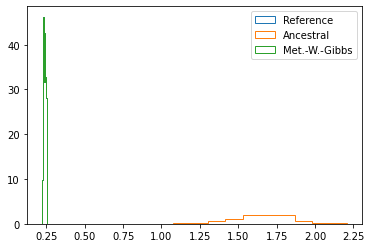

In [18]:
def compare_rogs(traj_xyz_ref, traj_xyz_anc, traj_xyz_mwg, topology, density = True, xlims = [0.2, 0.28], histtype = 'step'):
    rogs_ref = [radius_of_gyration(xyz, topology = topology) for xyz in traj_xyz_ref]
    rogs_anc = [radius_of_gyration(xyz, topology = topology) for xyz in traj_xyz_anc]
    rogs_mwg = [radius_of_gyration(xyz, topology = topology) for xyz in traj_xyz_mwg]
    
    plt.hist(rogs_ref, density = density, histtype = histtype, label = "Reference")
    plt.hist(rogs_anc, density = density, histtype = histtype, label = "Ancestral")
    plt.hist(rogs_ref, density = density, histtype = histtype, label = "Met.-W.-Gibbs")
    
    #plt.xlim(xlims)
    plt.legend()
    plt.show()
    plt.close()
    
    return rogs_ref, rogs_anc, rogs_mwg

rogs_ref, rogs_anc, rogs_mwg = compare_rogs(traj_xyz_ref = traj_xyz, traj_xyz_anc = x_recon, traj_xyz_mwg = xyz_samples ,topology = traj.topology)